<a href="https://colab.research.google.com/github/airoprojects/visiope/blob/main/experiments/test_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 16.0 MB/s eta 0:00:00


In [32]:
# General imports

import os
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as metrics
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import random

In [4]:
# Custom Imports

COLAB = 'google.colab' in sys.modules
LOCAL = not COLAB

if COLAB:

    # Clone visiope repo on runtime env
    !git clone https://github.com/airoprojects/visiope.git /content/visiope/
    %cd ./visiope/
    !git checkout tests
    !git branch
    %cd ../

    # Get the root directory of the Git project
    root_dir = '/content/visiope'

    # Add custom modules to path
    custom_modules_path = root_dir + '/tools/'
    sys.path.insert(0, custom_modules_path)

elif LOCAL:

    from git import Repo

    # Initialize the Git repository object
    repo = Repo(".", search_parent_directories=True)

    # Get the root directory of the Git project
    root_dir = repo.git.rev_parse("--show-toplevel")

    # Add custom modules to path
    custom_modules_path = root_dir  + '/tools/'
    sys.path.insert(0, custom_modules_path)


# Import Loader
from data.utils import Ai4MarsDownload, Ai4MarsImporter, Ai4MarsSplitter, Ai4MarsDataLoader

# Import Loss
from loss.loss import Ai4MarsCrossEntropy, Ai4MarsDiceLoss

# Import Trainer
from trainer.trainer import Ai4MarsTrainer

# Import Tester
from tester.tester import Ai4MarsTester

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cloning into '/content/visiope'...
remote: Enumerating objects: 1324, done.
remote: Counting objects: 100% (333/333), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 1324 (delta 159), reused 279 (delta 141), pack-reused 991
Receiving objects: 100% (1324/1324), 220.42 MiB | 29.50 MiB/s, done.
Resolving deltas: 100% (694/694), done.
/content/visiope
Branch 'tests' set up to track remote branch 'tests' from 'origin'.
Switched to a new branch 'tests'
  main
* tests
/content


In [ ]:
# Dataloader

# Set this to True if you wnat to load directly the dataloader
# this can be done only on colab and it is useful to avoid runtime crash
LOAD = True

if LOAD:

    if COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/104YvO3LcU76euuVe-_62eS_Rld-tOZeh?usp=drive_link'

            !gdown --folder {url} -O /content/

            load_data = '/content/dataset/dataset.pt'

    elif LOCAL:
        load_data = root_dir + '/datasetup/dataset/dataset.pt'

    X, y = torch.load(load_data)

    # Build dataset
    splitter = Ai4MarsSplitter()
    train_set, test_set, val_set = splitter(X, y, [0.7, 0.2, 0.1])

    # Load dataset info
    load_info = './.info.pt'
    info = torch.load(load_info)

    # Build Ai4MarsDataloader
    loader = Ai4MarsDataLoader()
    train_loader, test_loader, val_loader = loader(
        [train_set, test_set, val_set], [32, 16, 16])


else:

    # Insert here your local path to the dataset (temporary)
    data_path ='/home/leeoos/Desktop/' #input("Path to Dataset: ")

    # Insert here the number of images you want to download
    num_images = 100 #int(input("Number of images (max 1000): "))

    save_path = None
    # Uncomment the following line to the dataset on a local path
    #save_path = root_dir + '/datasetup/dataset/'

    if num_images > 1000 : raise Exception("Trying to import too many images")

    # Import data as Ai4MarsDataset
    Ai4MarsDownload()(PATH=data_path)
    importer = Ai4MarsImporter()
    X, y, _ = importer(PATH=data_path, NUM_IMAGES=num_images, SAVE_PATH=save_path, SIZE=128)

    transform = None
    # Uncomment the following lines to apply transformations to the dataset
    '''
    transform = transforms.RandomChoice([
     transforms.RandomRotation(90)])
    '''

    # Load info
    load_info = './.info.pt'
    info = torch.load(load_info)

    # Split the dataset
    splitter = Ai4MarsSplitter()
    train_set, test_set, val_set = splitter(X, y, [0.7, 0.2, 0.1], transform=transform,
                                            SAVE_PATH=save_path)

    # Build Ai4MarsDataloader
    loader = Ai4MarsDataLoader()
    train_loader, test_loader, val_loader = loader([train_set, test_set, val_set], [32, 16, 16],
                                                   SAVE_PATH=save_path)

In [40]:
from semseg.datasets import *
palette = eval('ADE20K').PALETTE



def printSegmentationImage(pred):
  # x = torch.tensor([])




  pred = pred.softmax(1).argmax(1).to(int)
  pred.unique()

  seg_map = palette[pred.cpu()].squeeze().to(torch.uint8)

  seg_map.to(device)

  print(seg_map)
  print(seg_map.shape)

  plt.imshow(seg_map, cmap='gray')
  plt.show()

  print(palette[pred.cpu()])
  print(pred)
  print(pred.shape)
  print(palette[pred.cpu()].shape)





11200
3200
1600
image shape: torch.Size([128, 128, 3])


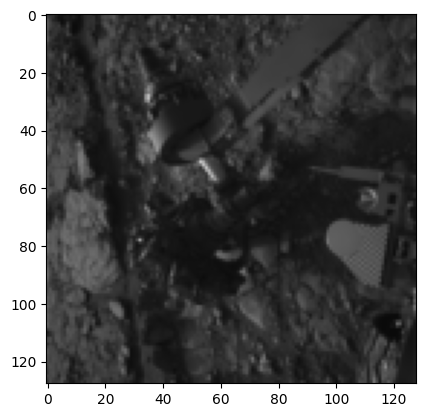

image shape: torch.Size([128, 128, 1])


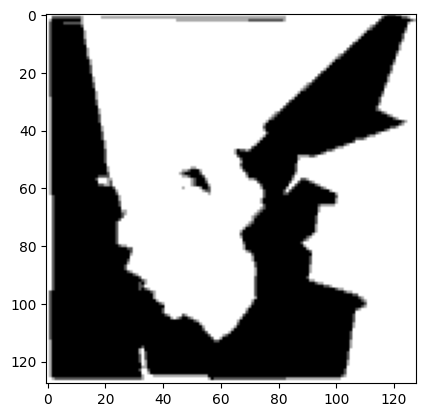

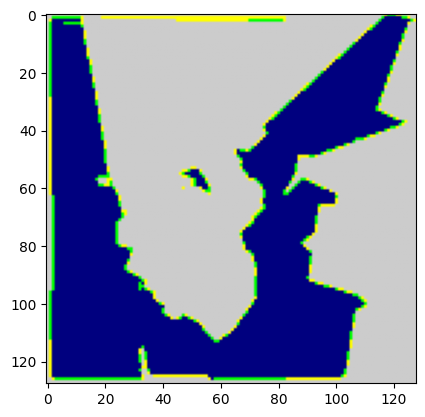

image shape: torch.Size([128, 128, 3])


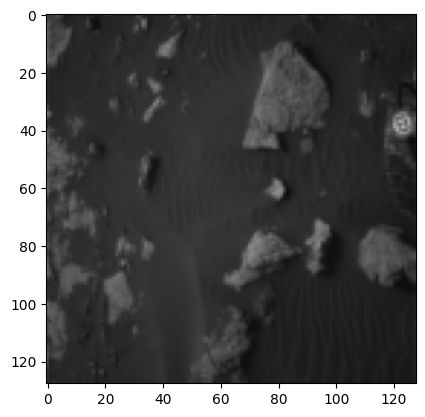

image shape: torch.Size([128, 128, 1])


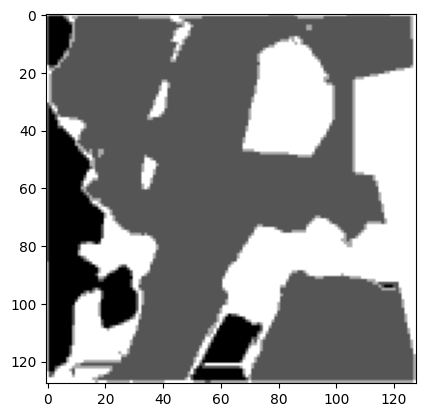

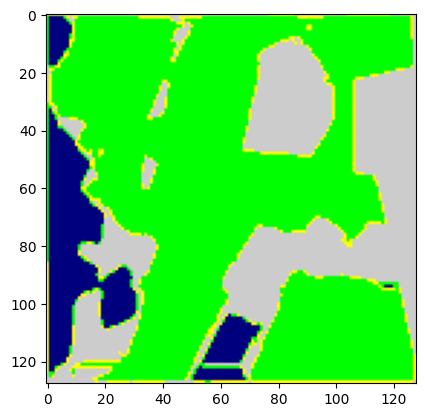

torch.Size([1, 128, 128])


In [54]:
import matplotlib.pyplot as plt

print(len(train_set))
print(len(test_set))
print(len(val_set))

image, label = train_set.__getitem__(0)

print(f'image shape: {image.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(image.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

print(f'image shape: {label.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(label.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()


visualize_labels(label[0].squeeze())

k = 0
for image, label in train_loader:
    if k == 1: break
    k += 1

print(f'image shape: {image[0].permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(image[0].permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

print(f'image shape: {label[0].permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(label[0].permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()






visualize_labels(label[0].squeeze())








random_sample = random.sample(range(len(test_loader.dataset)), 1)


print(label[0].shape)
model.eval()

for i in random_sample:
  image = test_loader.dataset.__getitem__(i)[0]
  label = test_loader.dataset.__getitem__(i)[1]

  image2 = image
  pred = model(image2.unsqueeze(0).to(device))

  label2 = label











In [53]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_labels(labels):
    color_map = {
        0: [1, 0, 0],    # red
        1: [0, 0, 0.5],    # blue
        2: [0, 1, 0],    # green
        3: [1, 1, 0],    # yellow
        4: [0.8, 0.8, 0.8],    # white
    }

    # Convert labels to numpy array
    labels = np.array(labels)

    # Create an empty RGB image with the same shape as labels
    height, width = labels.shape
    image = np.zeros((height, width, 3))

    # Map labels to colors
    for i in range(height):
        for j in range(width):
            image[i, j] = color_map[labels[i, j]]

    # Display the image
    plt.imshow(image)
    plt.show()

In [ ]:
# Clone remote repo with existing models

if COLAB:
    !git clone https://github.com/sithu31296/semantic-segmentation
    %cd semantic-segmentation
    %pip install -e .
    %pip install -U gdown

In [22]:
#  Import segformer

from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B1',
    num_classes=5
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth',
                                     map_location=device))
    print("Pretrained model's weights downloaded")
except:
    print("Download a pretrained model's weights from the result table.")

model.to(device)

print('Loaded Model')

Loaded Model


In [ ]:
# Training parameters

loss_fn = Ai4MarsDiceLoss().to(device)
#loss_fn = Ai4MarsCrossEntropy().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
transform = transforms.RandomChoice([
     transforms.RandomRotation(90)])

trainer = Ai4MarsTrainer(loss_fn, optimizer, train_loader, val_loader,
                         transform=transform, device=device, info=info, model_name='MiT-B1', dump=True)

In [ ]:
# Module Parameters
trainer.param_hist(model, SAVE_PATH=root_dir+'/experiments', label='before')

In [ ]:
# Start training
trainer.train_multiple_epoch(model, EPOCHS=5, SAVE_PATH=root_dir+'/experiments')

In [ ]:
a = None
print('ciao' + str(a))

In [ ]:
# Plot loss

import matplotlib.pyplot as plt

trainer.plot_loss(model=model, SAVE_PATH=root_dir+'/experiments')

In [ ]:
# Testing and evaluation Metrics

metric = metrics.JaccardIndex(task="multiclass", num_classes=5).to(device)
tester = Ai4MarsTester(loss_fn, metric, test_loader, device=device)

In [ ]:
# Start testing

tester.test_one_epoch(model)

In [ ]:
# Module Parameters
trainer.param_hist(model, SAVE_PATH=root_dir+'/experiments', label='after')